# Optimizing a Neural Network for March Madness Bracket Predictions
(with Keras)

I achieved an average bracket score of 92 with an xgboost model. I will see if a neural network can do better.

More specifically, I will build Siamese neural network. This is an artificial neural network that uses two "twin" subnetworks with the same exact weights, but takes two different input vectors. In this case, one will take team 1 stats and the other will take team 2 stats. Then, there will be a concatenation layer that combines the two outputs from the subnetworks while capturing the interactions between them. Finally, a distance metric will be used to determine a winner.

First, I will just optimize for accuracy to get a feel for how this model will work, and then I will use the more complex simulation for optimization that uses the official bracket scoring (same as I did with the XGBoost model).

In [539]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from keras.regularizers import l2
from keras.optimizers import Adagrad, Adam, SGD
from keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL


In [499]:
data = pd.read_csv('/Users/jacksonisidor/Documents/March Madness Project/Deployment/all_matchup_stats.csv')
data.head()

,year,team_1,seed_1,round_1,current_round,team_2,seed_2,round_2,badj_em_1,badj_o_1,...,op_o_reb_percent_diff,blk_percent_diff,ast_percent_diff,pppo_diff,pppd_diff,exp_diff,eff_hgt_diff,talent_diff,elite_sos_diff,win_percent_diff
0,2024,Connecticut,1.0,2.0,64.0,Stetson,16.0,64.0,32.7,126.8,...,-4.4,6.4,15.0,0.118,-0.148,-0.345,0.266,38.308,21.670,0.298861
1,2024,Florida Atlantic,8.0,64.0,64.0,Northwestern,9.0,32.0,15.1,117.6,...,1.0,-2.1,-8.6,0.051,-0.010,0.478,-0.726,-13.666,-9.585,0.101326
2,2024,San Diego St.,5.0,16.0,64.0,UAB,12.0,64.0,17.4,111.8,...,-3.0,-0.4,1.2,-0.025,-0.102,0.288,0.071,21.475,11.670,0.020833
3,2024,Auburn,4.0,64.0,64.0,Yale,13.0,32.0,28.4,120.5,...,6.3,6.0,8.7,0.072,-0.062,0.283,0.466,34.318,11.823,0.104462
4,2024,BYU,6.0,64.0,64.0,Duquesne,11.0,32.0,21.7,120.2,...,-5.3,-5.0,9.4,0.121,0.002,0.247,1.055,19.350,10.414,0.020499


In [500]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82178 entries, 0 to 82177
Data columns (total 95 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   82178 non-null  int64  
 1   team_1                 82178 non-null  object 
 2   seed_1                 945 non-null    float64
 3   round_1                945 non-null    float64
 4   current_round          945 non-null    float64
 5   team_2                 82178 non-null  object 
 6   seed_2                 945 non-null    float64
 7   round_2                945 non-null    float64
 8   badj_em_1              82178 non-null  float64
 9   badj_o_1               82178 non-null  float64
 10  badj_d_1               82178 non-null  float64
 11  wab_1                  82178 non-null  float64
 12  barthag_1              82178 non-null  float64
 13  efg_1                  82178 non-null  float64
 14  efg_d_1                82178 non-null  float64
 15  ft

## Data Preparation

In [503]:
# Separate the predictors from the target variable
predictors = ['badj_em_1', 'badj_em_2', 'badj_o_1', 'badj_o_2', 'badj_d_1', 'badj_d_2', 
              'wab_1', 'wab_2', 'barthag_1', 'barthag_2', 'efg_1', 'efg_2', 'efg_d_1', 
              'efg_d_2', 'ft_rate_1', 'ft_rate_2', 'ft_rate_d_1', 'ft_rate_d_2', 
              'tov_percent_1', 'tov_percent_2', 'tov_percent_d_1', 'tov_percent_d_2', 
              'adj_tempo_1', 'adj_tempo_2', '3p_percent_1', '3p_percent_2', 
              '3p_rate_1', '3p_rate_2', '2p_percent_1', '2p_percent_2', 
              'o_reb_percent_1', 'o_reb_percent_2', 'op_o_reb_percent_1', 'op_o_reb_percent_2',
              'blk_percent_1', 'blk_percent_2', 'ast_percent_1', 'ast_percent_2',
              'pppo_1', 'pppo_2', 'pppd_1', 'pppd_2',
              'exp_1', 'exp_2', 'eff_hgt_1', 'eff_hgt_2', 'talent_1', 'talent_2', 'elite_sos_1', 
              'elite_sos_2', 'win_percent_1', 'win_percent_2']

target = "winner"

# tournament data for experimenting
t_data = data[data.type == 'T']

X = data[predictors]
y = data[target]

In [504]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) # 70% to train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 15% for val, 15% for unbiased testing

In [505]:
scaler = StandardScaler()

# Fit the scaler on the training predictors, then transform all X data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [506]:
# Extract team_1 and team_2 features separately for training
X_train_team_1 = X_train_scaled[:, :len(predictors)//2]
X_train_team_2 = X_train_scaled[:, len(predictors)//2:]

# Do the same for validation sets
X_val_team_1 = X_val_scaled[:, :len(predictors)//2]
X_val_team_2 = X_val_scaled[:, len(predictors)//2:]

# And for test sets
X_test_team_1 = X_test_scaled[:, :len(predictors)//2]
X_test_team_2 = X_test_scaled[:, len(predictors)//2:]

## Network Architecture

In [507]:
# Define the subnetwork
def create_subnet(input_shape):
    input_layer = Input(shape=input_shape)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.00046))(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.189)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.00046))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.189)(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.00046))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.189)(x)
    return Model(inputs=input_layer, outputs=x)

In [508]:
# Apply the subnetwork to each team
input_shape = (X_train_team_1.shape[1],) # both sets teams are the same input_shape
team_1_input = Input(shape=input_shape)
team_2_input = Input(shape=input_shape)
shared_subnet = create_subnet(input_shape)
team_1_embedding = shared_subnet(team_1_input)
team_2_embedding = shared_subnet(team_2_input)

# Combine the embeddings
combined_embeddings = concatenate([team_1_embedding, team_2_embedding])

# Add layers for interaction capture (may identify trends in how adversarial team stats interact)
dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.00046))(combined_embeddings)
dense1 = BatchNormalization()(dense1)
dense1 = Dropout(0.189)(dense1)

dense2 = Dense(64, activation='relu', kernel_regularizer=l2(0.00046))(dense1)
dense2 = BatchNormalization()(dense2)
dense2 = Dropout(0.189)(dense2)

# Output layer with sigmoid function for binary classification
output = Dense(1, activation='sigmoid')(combined_embeddings)


In [509]:
# Define and compile the model
model = Model(inputs=[team_1_input, team_2_input], outputs=output)

optimizers = {
    'Adagrad': Adagrad(),
    'Adam': Adam(),
    'SGD': SGD()
}
selected_optimizer = 'Adagrad'
model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Train Model

In [510]:
history = model.fit(
    [X_train_team_1, X_train_team_2], y_train,
    validation_data = ([X_val_team_1, X_val_team_2], y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 7s 973us/step - accuracy: 0.7267 - loss: 0.5744 - val_accuracy: 0.7523 - val_loss: 0.5147
Epoch 2/50
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.7423 - loss: 0.5321 - val_accuracy: 0.7523 - val_loss: 0.5318
Epoch 3/50
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.7409 - loss: 0.5356 - val_accuracy: 0.7451 - val_loss: 0.5177
Epoch 4/50
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.7409 - loss: 0.5342 - val_accuracy: 0.7461 - val_loss: 0.5290
Epoch 5/50
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - accuracy: 0.7394 - loss: 0.5317 - val_accuracy: 0.7533 - val_loss: 0.5085
Epoch 6/50
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.7449 - loss: 0.5246 - val_accuracy: 0.7504 - val_loss: 0.5180
Epoch 7/50
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.7397 - loss: 0.5287 - val_accuracy: 0.7558 - val_loss: 0.5101
Epoch 8/50
1798/1798 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step - accuracy: 0.7431 -

## Evaluate Model

In [450]:
test_loss, test_accuracy = model.evaluate([X_test_team_1, X_test_team_2], y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

386/386 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step - accuracy: 0.7577 - loss: 0.4968
Test Loss: 0.5032239556312561
Test Accuracy: 0.754664957523346


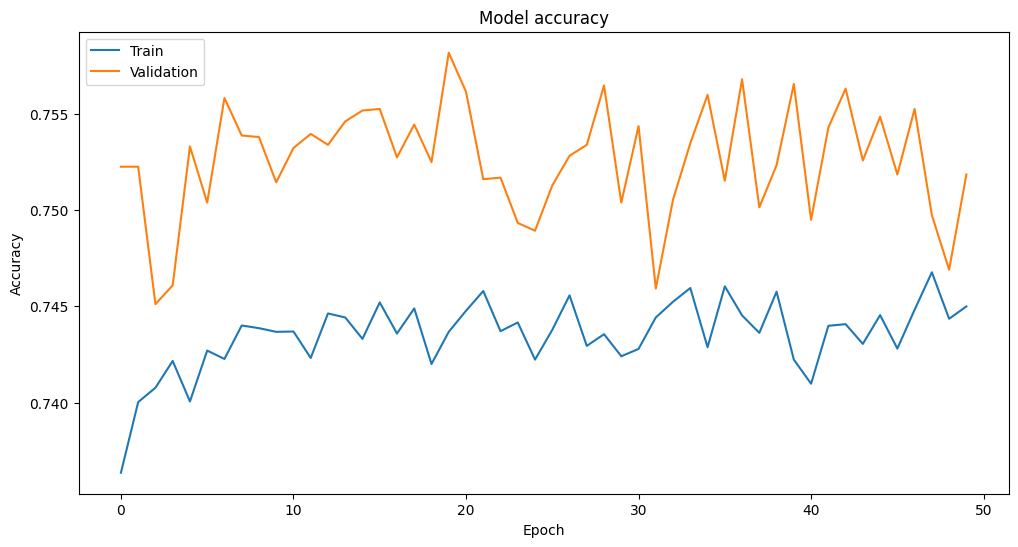

In [511]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Hyperparameter Tuning (for accuracy/loss)
Using the hyperopt library (Bayesian optimization, specifically TPE)

In [326]:
# Overall objective function
def objective(params, stat):

    input_shape = (X_train_team_1.shape[1],) # both sets teams are the same input_shape
    team_1_input = Input(shape=input_shape)
    team_2_input = Input(shape=input_shape)

    # Define the subnetwork
    def create_subnet(input_shape):
        input_layer = Input(shape=input_shape)
        x = Dense(int(params['units1']),
                             activation='relu',
                             kernel_regularizer=l2(params['l2']))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(params['dropout'])(x)
        x = Dense(int(params['units2']),
                             activation='relu',
                             kernel_regularizer=l2(params['l2']))(x)
        x = BatchNormalization()(x)
        x = Dropout(params['dropout'])(x)
        x = Dense(int(params['units3']),
                             activation='relu',
                             kernel_regularizer=l2(params['l2']))(x)
        x = BatchNormalization()(x)
        x = Dropout(params['dropout'])(x)
        return Model(inputs=input_layer, outputs=x)
    
    # Apply the subnetwork to each team
    shared_subnet = create_subnet(input_shape)
    team_1_embedding = shared_subnet(team_1_input)
    team_2_embedding = shared_subnet(team_2_input)

    # Combine the embeddings
    combined_embeddings = concatenate([team_1_embedding, team_2_embedding])

    # Add layers for interaction capture (may identify trends in how adversarial team stats interact)
    dense1 = Dense(int(params['units4']),
                       activation='relu',
                       kernel_regularizer=l2(params['l2']))(combined_embeddings)
    dense2 = Dense(int(params['units5']),
                       activation='relu',
                       kernel_regularizer=l2(params['l2']))(dense1)

    # Output layer with sigmoid function for binary classification
    output = Dense(1, activation='sigmoid')(dense2)

    # Define and compile the model
    model = Model(inputs=[team_1_input, team_2_input], outputs=output)

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),  
                loss='binary_crossentropy', 
                metrics=['accuracy'])
    
    # To minimize loss
    if stat == 'loss':
        # Train the model with early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(
            [X_train_team_1, X_train_team_2], y_train,
            validation_data = ([X_val_team_1, X_val_team_2], y_val),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0
        )
    
        # Return the validation loss as the metric to minimize
        val_loss = min(history.history['val_loss'])
        return {'loss': val_loss, 'status': STATUS_OK}
    
        
    # To maximize accuracy
    if stat == 'accuracy':
        # Train the model with early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(
            [X_train_team_1, X_train_team_2], y_train,
            validation_data = ([X_val_team_1, X_val_team_2], y_val),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0
        )
    
        # Return the validation accuracy as the metric to maximize
        val_accuracy = max(history.history['val_accuracy'])
        return {'loss': -val_accuracy, 'status': STATUS_OK}


In [313]:
# Define the hyperparameter space
space = {
    'units1': hp.quniform('units1', 32, 256, 32),
    'units2': hp.quniform('units2', 32, 256, 32),
    'units3': hp.quniform('units3', 32, 256, 32),
    'units4': hp.quniform('units4', 32, 256, 32),
    'units5': hp.quniform('units5', 32, 256, 32),
    'dropout': hp.uniform('dropout', 0.1, 0.5),
    'l2': hp.uniform('l2', 0.0001, 0.01),
    'learning_rate': hp.loguniform('learning_rate', -5, -2)
}

Minimize loss:

In [316]:
trials = Trials()
best = fmin(lambda params: objective(params, 'loss'), space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Best hyperparameters (loss):", best)

100%|██████████| 50/50 [1:17:50<00:00, 93.42s/trial, best loss: 0.5034419298171997] 
Best hyperparameters: {'dropout': 0.22743265495209788, 'l2': 0.00010692839149588807, 'learning_rate': 0.01014987077499302, 'units1': 32.0, 'units2': 224.0, 'units3': 256.0, 'units4': 32.0, 'units5': 128.0}


Minimize accuracy:

In [327]:
trials = Trials()
best = fmin(lambda params: objective(params, 'accuracy'), space, algo=tpe.suggest, max_evals=100, trials=trials)
print("Best hyperparameters (accuracy):", best)

100%|██████████| 100/100 [1:53:46<00:00, 68.27s/trial, best loss: -0.7573224902153015] 
Best hyperparameters (accuracy): {'dropout': 0.18868856622068603, 'l2': 0.00046141774243777125, 'learning_rate': 0.010861504855446565, 'units1': 32.0, 'units2': 32.0, 'units3': 32.0, 'units4': 64.0, 'units5': 64.0}


Instead of copy and pasting all the network architecture again, I will just go up and change to these optimal hyperparameters. 

Interestingly, I am not seeing any improvement after hyperparameter tuning. I also added more features and am still seeing the same results. Model complexity also does not seem to affect much. Fortunately, the accuracy we have (~75%) is better than the XGBoost model anyways (~71%). I will now use this model in my simulation to see how it scores on a full bracket.

## Full Bracket Simulation
I will copy over the simulation that I've been using, but will put the neural network model where the XGBoost model was. 

In [541]:
# Scoring function
def score_bracket(predicted, actual):
    
    score = 0
    for (pred_index, pred_matchup), (act_index, act_matchup) in zip(predicted.iterrows(), actual.iterrows()):
        
        if (pred_matchup["team_1"] == act_matchup["team_1"]) and (pred_matchup["prediction"] == act_matchup["winner"] == 1):
            score += 64 / pred_matchup["current_round"]
            
        elif (pred_matchup["team_2"] == act_matchup["team_2"]) and (pred_matchup["prediction"] == act_matchup["winner"] == 0): 
            score += 64 / pred_matchup["current_round"]
            
    return score

# Function to get the info from the winning team to pass to the next round
def get_winner_info(matchups):
    next_round_teams_list = []
    
    for index, matchup in matchups.iterrows():
        # if team_1 wins, get all info that ends in "_1"
        if matchup["prediction"] == 1:
            winning_team_info = matchup.filter(regex='_1$').rename(lambda x: x[:-2], axis=0)
        # if team_2 wins, get all info that ends in "_2"
        else:
            winning_team_info = matchup.filter(regex='_2$').rename(lambda x: x[:-2], axis=0)
        
        winning_team_info["year"] = matchup["year"]
        winning_team_info["current_round"] = matchup["current_round"] / 2
        
        next_round_teams_list.append(pd.DataFrame(winning_team_info).T)
    
    next_round_teams = pd.concat(next_round_teams_list, ignore_index=True)
        
    return next_round_teams

# Function to get the next round matchups (pass the winning teams on)
def next_sim_matchups(winning_teams):
    matchups = pd.DataFrame(columns=['year', 'team_1', 'seed_1', 'round_1', 'current_round', 'team_2', 'seed_2', 'round_2'])

    matchup_info_list = []
    # iterate through data frame and jump 2 each iteration
    for i in range(0, len(winning_teams)-1, 2):
        team1_info = winning_teams.iloc[i]
        team2_info = winning_teams.iloc[i+1]

        matchup_info = {
                    'year': team1_info['year'],
                    'team_1': team1_info['team'],
                    'seed_1': team1_info['seed'],
                    'round_1': team1_info['round'],
                    'current_round': team1_info['current_round'],
                    'team_2': team2_info['team'],
                    'seed_2': team2_info['seed'],
                    'round_2': team2_info['round'],
                    'badj_em_1': team1_info['badj_em'],
                    'badj_o_1': team1_info['badj_o'],
                    'badj_d_1': team1_info['badj_d'],
                    'wab_1': team1_info['wab'],
                    'barthag_1': team1_info['barthag'],
                    'efg_1': team1_info['efg'],
                    'efg_d_1': team1_info['efg_d'],
                    'ft_rate_1': team1_info['ft_rate'],
                    'ft_rate_d_1': team1_info['ft_rate_d'],
                    'tov_percent_1': team1_info['tov_percent'],
                    'tov_percent_d_1': team1_info['tov_percent_d'],
                    'o_reb_percent_1': team1_info['o_reb_percent'],
                    'op_o_reb_percent_1': team1_info['op_o_reb_percent'],
                    'blk_percent_1': team1_info['blk_percent'],
                    'ast_percent_1': team1_info['ast_percent'],
                    'adj_tempo_1': team1_info['adj_tempo'],
                    '3p_percent_1': team1_info['3p_percent'],
                    '3p_rate_1': team1_info['3p_rate'],
                    '2p_percent_1': team1_info['2p_percent'],
                    '3p_percent_d_1': team1_info['2p_percent_d'],
                    '2p_percent_d_1': team1_info['2p_percent_d'],
                    'pppo_1': team1_info['pppo'],
                    'pppd_1': team1_info['pppd'],
                    'exp_1': team1_info['exp'],
                    'eff_hgt_1': team1_info['eff_hgt'],
                    'talent_1' : team1_info['talent'],
                    'elite_sos_1': team1_info['elite_sos'],
                    'win_percent_1': team1_info['win_percent'],
                    'badj_em_2': team2_info['badj_em'],
                    'badj_o_2': team2_info['badj_o'],
                    'badj_d_2': team2_info['badj_d'],
                    'wab_2': team2_info['wab'],
                    'barthag_2': team2_info['barthag'],
                    'efg_2': team2_info['efg'],
                    'efg_d_2': team2_info['efg_d'],
                    'ft_rate_2': team2_info['ft_rate'],
                    'ft_rate_d_2': team2_info['ft_rate_d'],
                    'tov_percent_2': team2_info['tov_percent'],
                    'tov_percent_d_2': team2_info['tov_percent_d'],
                    'o_reb_percent_2': team1_info['o_reb_percent'],
                    'op_o_reb_percent_2': team1_info['op_o_reb_percent'],
                    'blk_percent_2': team1_info['blk_percent'],
                    'ast_percent_2': team1_info['ast_percent'],
                    'adj_tempo_2': team2_info['adj_tempo'],
                    '3p_percent_2': team2_info['3p_percent'],
                    '3p_rate_2': team2_info['3p_rate'],
                    '2p_percent_2': team2_info['2p_percent'],
                    '3p_percent_d_2': team2_info['3p_percent_d'],
                    '2p_percent_d_2': team2_info['2p_percent_d'],
                    'pppo_2': team1_info['pppo'],
                    'pppd_2': team1_info['pppd'],
                    'exp_2': team2_info['exp'],
                    'eff_hgt_2': team2_info['eff_hgt'],
                    'talent_2' : team2_info['talent'],
                    'elite_sos_2': team2_info['elite_sos'],
                    'win_percent_2': team2_info['win_percent']
                    }
    
        matchup_info_list.append(matchup_info)

    matchups = pd.concat([matchups, pd.DataFrame(matchup_info_list)])
            
    # get the stat differences same as before
    stat_variables = [
            'badj_em', 'badj_o', 'badj_d', 'wab', 'barthag', 'efg', 'efg_d', 'ft_rate', 'ft_rate_d', 'tov_percent',
            'tov_percent_d', 'adj_tempo', '3p_percent', '3p_rate', '3p_percent_d', '2p_percent', '2p_percent_d', 
            'o_reb_percent', 'op_o_reb_percent', 'blk_percent', 'ast_percent', 'pppo', 'pppd',
            'exp', 'eff_hgt', 'talent', 'elite_sos', 'win_percent'
    ]
    for variable in stat_variables:
        matchups[f'{variable}_diff'] = matchups[f'{variable}_1'] - matchups[f'{variable}_2']
            
    return matchups

# Main function to simulate the full bracket
def sim_bracket(round_matchups, model, predictors):

    # get team 1 and team 2 data into separate data frames to feed into the subnetworks
    team_1_predictors = [feat for feat in predictors if feat.endswith('_1')]
    team_2_predictors = [feat for feat in predictors if feat.endswith('_2')]
    team_1_stats = round_matchups[team_1_predictors]
    team_2_stats = round_matchups[team_2_predictors]
    
    # get predictions and probabilities for each game in the current round and add that column to the df
    predictions = model.predict([team_1_stats, team_2_stats], verbose=0) # binary classification outputs predictions as probabilities
    threshold = 0.5 
    predicted_labels = (predictions > threshold).astype(int)

    round_matchups = round_matchups.copy()
    round_matchups.loc[:, "prediction"] = predicted_labels
    round_matchups.loc[:, "win probability"] = predictions

    
    # base case for recursion (we are in the championship round)
    if round_matchups["current_round"].iloc[0] == 2:
        return round_matchups
    
    # pass teams on to the next round in a new df and combine them into new matchups
    next_round_teams = get_winner_info(round_matchups)
    next_round_matchups = next_sim_matchups(next_round_teams)

    # recurse through making a simulated df that mimics the structure of the actual df
    return pd.concat([round_matchups, sim_bracket(next_round_matchups, model, predictors)], ignore_index=True)

Cross validation where I predict the bracket for each year after training on all games that occured outside of that year's tournament (includes both regular season games from that season and all games from any other season)

In [542]:
# Note that 'model' is what is stored from above and 'predictors' is already stored as well
scores = pd.DataFrame(columns=["year", "score"])
for year in data["year"].unique():
    # Split data leaving out 1 year for testing
    if year != 2020 and year != 2021:
        test = data[(data["year"] == year) & (data["type"] == "T")]
        train = data[(data["year"] != year) | 
                ((data["year"] == year) & (data["type"] != "T"))]
        X_train = train[predictors]
        y_train = train[target]

    # Simulate the test bracket 
    test_r64 = test[test["current_round"] == 64]
    prediction_bracket = sim_bracket(test_r64, model, predictors)

    # Score the test bracket
    score = score_bracket(prediction_bracket, test)
    
    # add to df
    test_bracket_info = pd.DataFrame({'year': [year], 'score': [score]})
    scores = pd.concat([scores, test_bracket_info], ignore_index=True)

In [543]:
scores

,year,score
0,2024,79.0
1,2023,41.0
2,2022,42.0
3,2019,66.0
4,2018,77.0
5,2017,64.0
6,2016,79.0
7,2015,79.0
8,2014,50.0
9,2013,90.0


In [544]:
scores.score.mean()

70.375

These scores are pretty bad. I will now do the hyperparameter tuning, but on the simulation to optimize the average bracket score. 

## Hyperparameter Tuning (for average bracket score)

In [540]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define the objective function (this time, it goes through each year in the data and sims the bracket)
def objective2(params):

    # Define the subnetwork
    def create_subnet(input_shape):
        input_layer = Input(shape=input_shape)
        x = Dense(int(params['units1']),
                             activation='relu',
                             kernel_regularizer=l2(params['l2']))(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(params['dropout'])(x)
        x = Dense(int(params['units2']),
                             activation='relu',
                             kernel_regularizer=l2(params['l2']))(x)
        x = BatchNormalization()(x)
        x = Dropout(params['dropout'])(x)
        x = Dense(int(params['units3']),
                             activation='relu',
                             kernel_regularizer=l2(params['l2']))(x)
        x = BatchNormalization()(x)
        x = Dropout(params['dropout'])(x)
        return Model(inputs=input_layer, outputs=x)

    total_score = 0
    team_1_predictors = [feat for feat in predictors if feat.endswith('_1')]
    team_2_predictors = [feat for feat in predictors if feat.endswith('_2')]

    try: 
        # Iterate over each year in the dataset
        for year in data["year"].unique():
            if year != 2020 and year != 2021:
                # Split data leaving out 1 year for testing
                test = data[(data["year"] == year) & (data["type"] == "T")]
                train = data[(data["year"] != year) | 
                        ((data["year"] == year) & (data["type"] != "T"))]
                
                # Split the training data further into train and val for fitting
                train, val = train_test_split(train, test_size=0.2, random_state=42) 
                X_train = train[predictors]
                y_train = train[target]
                X_val = val[predictors]
                y_val = val[target]

                # Extract predictors for team 1 and team 2
                X_train_team_1_stats = X_train[team_1_predictors]
                X_train_team_2_stats = X_train[team_2_predictors]
                X_val_team_1_stats = X_val[team_1_predictors]
                X_val_team_2_stats = X_val[team_2_predictors]

                input_shape = (X_train_team_1_stats.shape[1],) # both sets teams are the same input_shape
                team_1_input = Input(shape=input_shape)
                team_2_input = Input(shape=input_shape)

                # Apply the subnetwork to each team
                shared_subnet = create_subnet(input_shape)
                team_1_embedding = shared_subnet(team_1_input)
                team_2_embedding = shared_subnet(team_2_input)

                # Combine the embeddings
                combined_embeddings = concatenate([team_1_embedding, team_2_embedding])

                # Add layers for interaction capture (may identify trends in how adversarial team stats interact)
                dense1 = Dense(int(params['units4']),
                                activation='relu',
                                kernel_regularizer=l2(params['l2']))(combined_embeddings)
                dense2 = Dense(int(params['units5']),
                                activation='relu',
                                kernel_regularizer=l2(params['l2']))(dense1)

                # Output layer with sigmoid function for binary classification
                output = Dense(1, activation='sigmoid')(dense2)

                # Define and compile the model
                model = Model(inputs=[team_1_input, team_2_input], outputs=output)

                model.compile(optimizer=Adam(learning_rate=params['learning_rate']),  
                            loss='binary_crossentropy', 
                            metrics=['accuracy'])

                # Train the model with early stopping
                early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
                model.fit(
                        [X_train_team_1_stats, X_train_team_2_stats], y_train,
                        validation_data = ([X_val_team_1_stats, X_val_team_2_stats], y_val),
                        epochs=50,
                        batch_size=32,
                        callbacks=[early_stopping],
                        verbose=0
                    )

                # Simulate the test bracket 
                test_r64 = test[test["current_round"] == 64]
                prediction_bracket = sim_bracket(test_r64, model, predictors)

                # Score the test bracket
                score = score_bracket(prediction_bracket, test)

                # Add the score to the total
                total_score += score
            
        
        # Calculate the average score
        average_score = total_score / (len(data["year"].unique()))
        
        # Return the negative of the average score (to minimize)
        return -average_score
    
    except Exception as e: 
        logger.error(f"Error with parameters: {params}, Error: {e}")
        return {'loss': float('inf'), 'status': STATUS_FAIL}

In [517]:
# Define the hyperparameter space
space = {
    'units1': hp.quniform('units1', 32, 256, 32),
    'units2': hp.quniform('units2', 32, 256, 32),
    'units3': hp.quniform('units3', 32, 256, 32),
    'units4': hp.quniform('units4', 32, 256, 32),
    'units5': hp.quniform('units5', 32, 256, 32),
    'dropout': hp.uniform('dropout', 0.1, 0.5),
    'l2': hp.uniform('l2', 0.0001, 0.01),
    'learning_rate': hp.loguniform('learning_rate', -5, -2)
}

# Perform hyperparameter optimization
trials = Trials()
best = fmin(fn=objective2, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Best hyperparameters:", best)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14

job exception: Graph execution error:

Detected at node functional_2202_1/functional_2200_3/batch_normalization_1597_1/batchnorm/mul defined at (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Library/Frameworks/Python.framework/V

 40%|████      | 20/50 [5:54:31<8:51:47, 1063.58s/trial, best loss: -92.9375]


InvalidArgumentError: Graph execution error:

Detected at node functional_2202_1/functional_2200_3/batch_normalization_1597_1/batchnorm/mul defined at (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 728, in start

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 600, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/4l/944cj3pd4hn2cm3hpy927z600000gn/T/ipykernel_58999/2525775763.py", line 15, in <module>

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hyperopt/fmin.py", line 540, in fmin

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hyperopt/base.py", line 671, in fmin

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hyperopt/fmin.py", line 586, in fmin

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hyperopt/fmin.py", line 364, in exhaust

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hyperopt/fmin.py", line 300, in run

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hyperopt/fmin.py", line 178, in serial_evaluate

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/hyperopt/base.py", line 892, in evaluate

  File "/var/folders/4l/944cj3pd4hn2cm3hpy927z600000gn/T/ipykernel_58999/1283166367.py", line 80, in objective2

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 339, in fit

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 425, in evaluate

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 161, in one_step_on_iterator

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 150, in one_step_on_data

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 78, in test_step

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py", line 202, in call

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py", line 592, in call

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py", line 202, in call

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/function.py", line 155, in _run_through_graph

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py", line 592, in call

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/layer.py", line 846, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/operation.py", line 48, in __call__

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 250, in call

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/ops/nn.py", line 1808, in batch_normalization

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py", line 764, in batch_normalization

Incompatible shapes: [32] vs. [0]
	 [[{{node functional_2202_1/functional_2200_3/batch_normalization_1597_1/batchnorm/mul}}]] [Op:__inference_one_step_on_iterator_55379371]